# Mathematical Language Text Understanding with BERT

In this tutorial, we will be using BERT to predict the position of the definition of a mathematical variable given a variable name and the context in which it is defined.


## BERT
The BERT (Bidirectional Encoder Representations From) technique is a newer approach to training attention-based NLP models. It is implemented in two steps: pre-training and fine-tuning. In the fine-tuning step, a base-line transformer comprised of multiple bi-directional encoders and attention heads is trained on a large corpus of unlabeled text data. This allows the model to abstract information about a language such as sentence structure, sentiment, and context. The model is then adapted for a specific task in the fine-tuning step. In this step, an output layer specific to a certain NLP task is added to the model and trained on a specialized labeled dataset. For example, in the case of Bert for Question Answering (the model used in this tutorial), the final output layer is a feed-forward network that finds the the most likely indices of the answer. The figure below illustrates this. The Bert technique is successful because it allows a model to first learn the fundamentals of a language from the unsupervised learning in the pre-training step, which in turn bolsters the efficiency of the fine-tuning step.

<div>
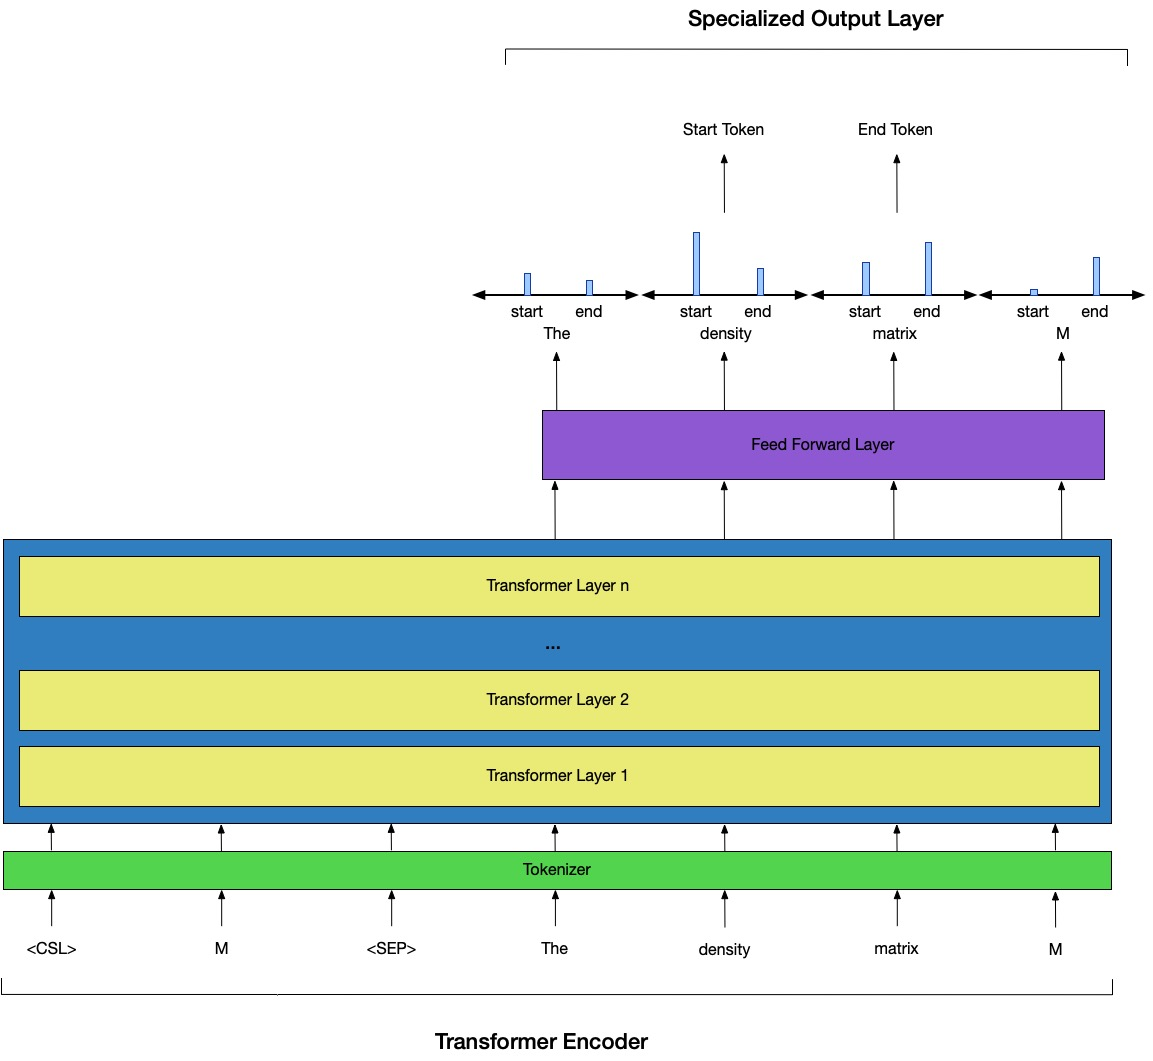
</div>

In this tutorial, we will fine-tuned the pre-trained Hugging Face BertForQuestionAnswering model to perform our definition-extraction task. Instead of a question text, we used the name of the variable we wanted to define. We used a custom Hugging Face tokenizer that was trained on a mathematical language corpus of education materials from courses from pre-k to college (see: https://arxiv.org/pdf/2106.07340.pdf). 

## Let's get started!
To start, we are going to clean each entry in the data set and find the start and end token of each output in the context text. Next, we will use a pre-made tokenizer to tokenize the input sequences. For this tutorial, we will being using the Huggingface BertForQuestionAnswering model and the Huggingface tokenizer and Trainer objects. For more information about the tokenizer and trainer objects, check the comments!

## The Data and How We Process It
The data used in this tutorial is sourced from mathematical and physics papers from arXiv and manually cleaned. For each entry in the dataset, we are given a variable name, the context in which it is defined, and an definition of the variable. The model should process the variable name and the context and should be able to predict the start and end positional tokens of output. 

A lot of the pre-processing work is done by the Huggingface tokenizer. However, we will still clean the input sequences, find the positional tokens for the outputs, and organize the data. 

In [ ]:
from transformers import BertForQuestionAnswering
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
import pandas as pd
import math
import torch
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
# This implementation was inspired by: https://huggingface.co/transformers/v3.3.1/custom_datasets.html

def get_idx(context, definition):
    """This function finds positional token of 'definition' in 'context'.
    We use this function over the Huggingface 'char_to_token' as sometimes
    the output is not in the context (like when the output is the singular version of word in the context).

    Args:
      context: the context in which the variable is defined
      definition: the definition of the variable

    Returns:
      The position of 'definition' in 'context'
    """
    context_split = context.split(" ")
    if definition in context_split:
        # base case, return the idx of the definition in the context
        idx = context_split.index(definition)
    else:
        # This should cover an edge case where the correct definition is the singular version
        # of the definition of the text. It finds the idx of the most similar word to the definition.
        max_common = 0
        most_likely_idx = 0
        for i in range(len(context_split)):
            word_dist = len(set(definition).intersection(set(context_split[i])))
            if max_common < word_dist:
                max_common = word_dist
                most_likely_idx = i

        idx = most_likely_idx

    return idx

def clean_text(text):
    """Strips text of any punctuation, converts to lower case, and gets rid of any 
    unnecessary white space. 

    Args:
      text: the uncleaned sentence.

    Returns:
        The cleaned sentence.
    """
    text = text.replace('"', '').lower().strip()
    text = text.replace(",", "").replace(".", "").replace("!", "").replace("?", "").replace("(", "").replace(")", "").replace(":", "").replace("|", " ").replace("  ", " ").strip().replace(";", "")
    text = text.split(" ")
    text = ' '.join(text)
    return text

def prep_data(dataset):
    """Prepares input data to be tokenized and converts output data to positional tokens.

    Args:
      dataset: dataframe containing uncleaned data.

    Returns:
        The data, cleaned and organized.
    """
    var_names = []
    contexts = []
    outputs = []

    for index, row in dataset.iterrows():
        var = clean_text(row["var"])
        context = clean_text(row["context"])
        definition = clean_text(row["def"])
        definition = definition.split(" ")
        
        var_names.append(var)
        contexts.append(context)
        outputs.append((get_idx(context, definition[0]), get_idx(context, definition[-1])))
        
    return var_names, contexts, outputs

def add_token_positions(encodings, answers):
    """This function adds the start and end positions of the definitions
    to encodings. 

    Args:
      encodings: an BatchEncodings object that contains the tokenized inputs
      answers: a list of tuples containing the start and end tokens of the outputs
    """
    start_positions = []
    end_positions = []
    j = 0
    for i in range(len(answers)):
        start_positions.append(answers[i][0])
        end_positions.append(answers[i][1])

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    
class BertDataset(torch.utils.data.Dataset):
    """This class organizes the data so that the Huggingface BERT model can process it."""
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
data = pd.read_csv("data.csv")

# Randomize the dataframe
data = data.sample(frac=1).reset_index(drop=True)

# we use a 80/20 split to partition the data into training and testing data
i = math.ceil(len(data) * 0.8)
train_dataset = data[:i]
test_dataset = data[i:]

# Clean and process the data
training_vars, training_inputs, training_outputs = prep_data(train_dataset)
testing_vars, testing_inputs, testing_outputs = prep_data(test_dataset)

# This object will tokenize and prepare our data to be processed by the model
# We use this particular tokenizer because it was trained on a corpus of mathematical text, much like our dataset
tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBERT-custom")

# Tokenize the input data
train_encodings = tokenizer(training_inputs, training_vars, truncation=True, padding=True)
test_encodings = tokenizer(testing_inputs, testing_vars, truncation=True, padding=True)

# Add output positional tokens
add_token_positions(train_encodings, training_outputs)
add_token_positions(test_encodings, testing_outputs)

# We need to wrap out data in this dataset object so the Trainer object can use the data
train_dataset = BertDataset(train_encodings)
test_dataset = BertDataset(test_encodings)

## Defining the Metrics
Before we run train and test the model, we need to define a function to pass to the Trainer object so it can evaulate the model. We use sklearn to find the accuracy and f1 score.

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=-1)

    y_true = list(np.array(labels).reshape(-1))
    y_pred = list(np.array(pred).reshape(-1))

    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    
    return {"f1": f1, "accuracy": accuracy}

## Putting It All Together
Now that we have all the important parts implemented, let's train and evaluate the model!

In [ ]:
# Play around with these variables!
lr = 0.00005
epochs = 3
batch_size = 8

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# The directory where the model predictions and checkpoints will be stored
output_dir = "./"

# This object gives the trainer object the arguments for its training and testing routines
# Default optimizer is adamw_hf
training_args = TrainingArguments(output_dir,
                                  per_device_train_batch_size=batch_size,
                                  learning_rate=lr,
                                  num_train_epochs=epochs,)

# The trainer object will perform the training and testing loops for you
# Note: Training this model usually takes a very long time
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset, compute_metrics=compute_metrics,)
trainer.train()
print(trainer.evaluate())